# ECG data preprocess version 2

Check some information with my tutor, I found there is some problems to fix about this little project, especially about the preprocess stage. I decide to try to divide the ecg signal into an ecg beat by the average time of RR interval.

In [1]:
# import some modules
import time
import numpy as np
import wfdb
import ast
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
from scipy.fftpack import fft, ifft 
from scipy import signal

## load data

to read the data correctly, you should put the jupyter files in the `code` folder, and all the datasets unzip in the `data` folder, also make sure the two folder are under the main folder.

`sampling_rate`: set the sample rate of the captured data, there are two options: 500 | 100 

In [2]:
# set filepath and sampling rate
path = '../data/'
sampling_rate = 500

In [3]:
# read label file and transfer it
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

load raw ecg function, based on the `example_physionet.py`

In [4]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [5]:
# get the ecg raw data
X = load_raw_data(Y, sampling_rate, path)

In [6]:
# get diagnose information
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)

In [7]:
agg_df = agg_df[agg_df.diagnostic == 1]

In [8]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [9]:
# add diagnose information
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

## figure and check the data

In [10]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_superclass'],
      dtype='object')

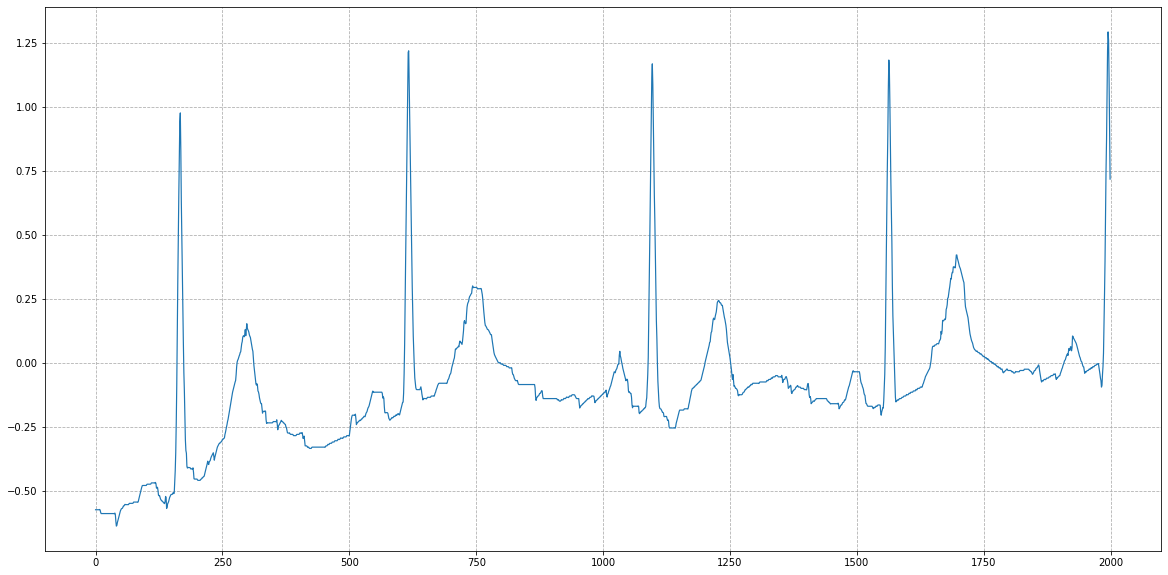

In [11]:
# check the ecg waves in lead II
plt.rcParams['figure.figsize'] = (20.0, 10.0) 
plt.figure()
plt.plot(X[4][:2000,1], linewidth=1.2)
plt.grid(linestyle='--')
# plt.yticks([])
plt.show()

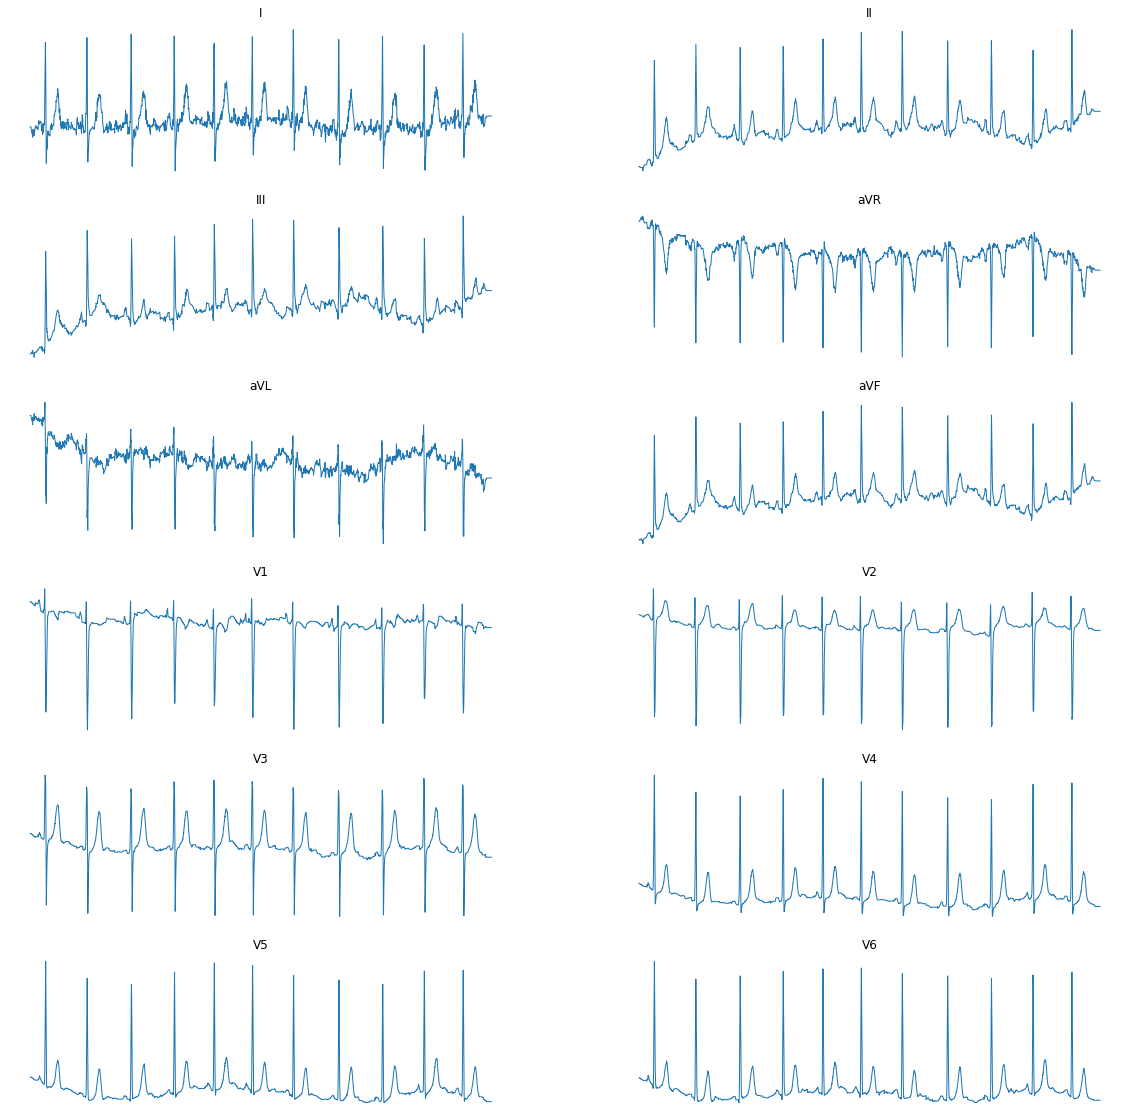

In [12]:
# check all 12 lead ecg data
ecg = X[4]
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = (0.1,0.1)
plt.figure()
for index in range(12):
    plt.subplot(6,2,index+1)
    plt.plot(ecg[:,index], linewidth=1)
    
    # plt.yticks(np.arange(np.min(ecg[:,index]), np.max(ecg[:,index]), 0.1))
    plt.gca()
    plt.title(titles[index])
    plt.axis('off')

plt.show()

## ecg signal denoise and de baseline

In [13]:
# fft function
def ecg_fft_ana(ecg_original, sampling_rate):
    fs = sampling_rate
    ts = 1.0/fs
    t = np.arange(0, 1, ts)
    n = len(ecg_original)
    k = np.arange(n)
    t = n/fs
    frq = k/t
    frq = frq[range(int(n/2))]
    fft_ecg = np.abs(fft(ecg_original))[range(int(n/2))]
    return frq, fft_ecg

In [14]:
# show fft difference of two signals
def show_spec_dif(ecg_original, ecg_filtered, title1="title1", title2 = "title2"):
    frq, fft_ecg = ecg_fft_ana(ecg_original, sampling_rate)
    frq_filtered, fft_ecg_filtered = ecg_fft_ana(ecg_filtered, sampling_rate)
    plt.figure()
    plt.subplot(221)
    plt.plot(ecg_original[:2000])
    plt.title(title1)
    plt.subplot(222)
    plt.plot(frq,fft_ecg)
    plt.title(title1 + '`s spectrum')
    plt.subplot(223)
    plt.plot(ecg_filtered[:2000])
    plt.title(title2)
    plt.subplot(224)
    plt.plot(frq_filtered, fft_ecg_filtered)
    plt.title(title2 + '`s spectrum')
    plt.show()

In [31]:
ecg_original = X[1024,:,0]
ecg_original2 = X[1000,:,0]

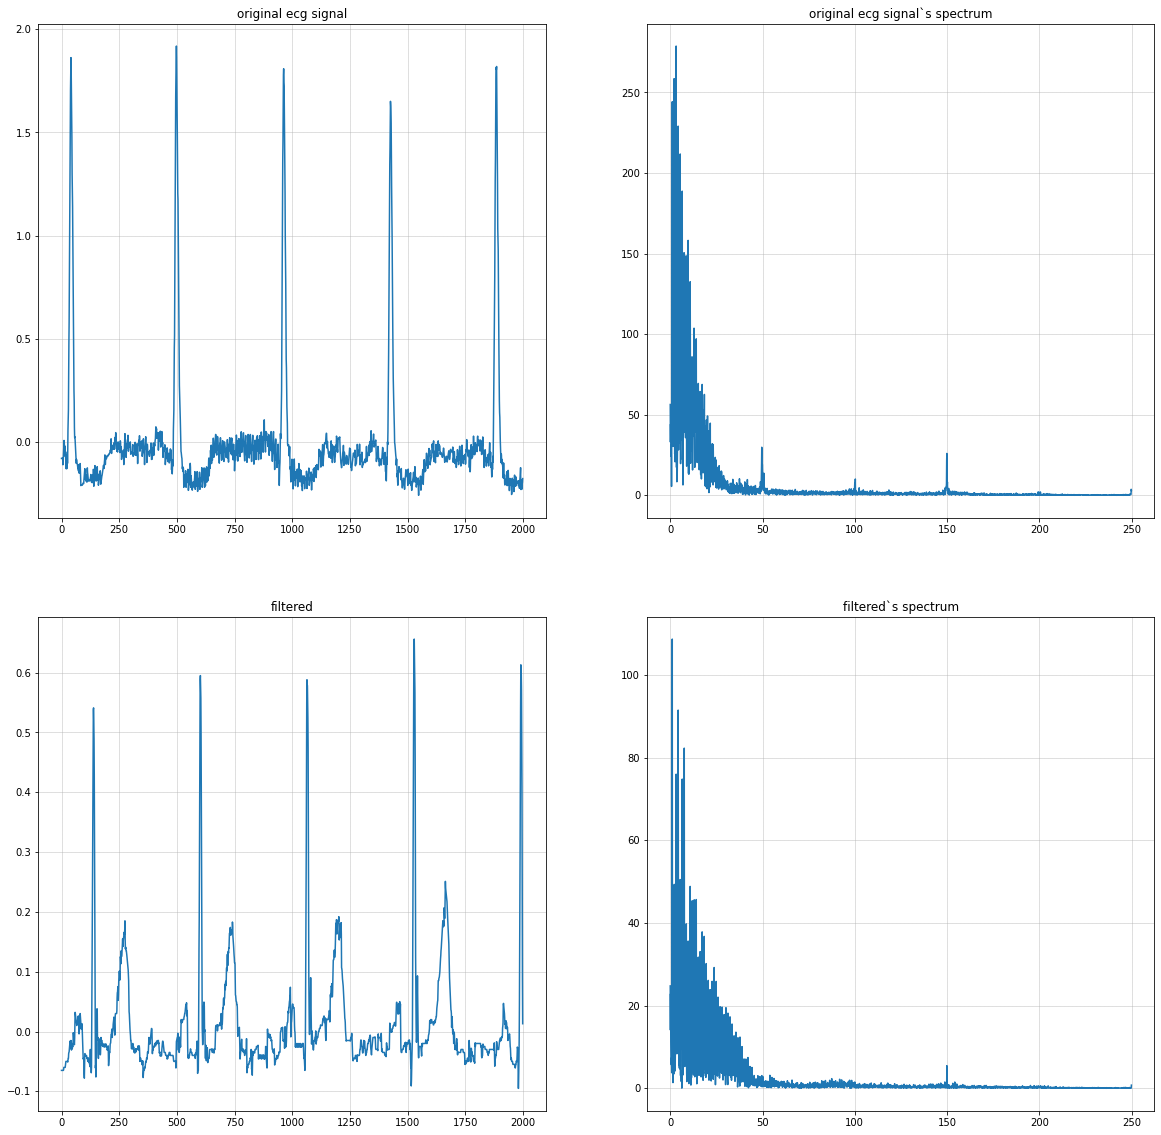

In [32]:
show_spec_dif(ecg_original, ecg_original2, 'original ecg signal', 'filtered')

In [17]:
# n points window filtering
def np_move_avg(a,n,mode="same"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))

In [33]:
ecg_filtered = np_move_avg(ecg_original, 7)

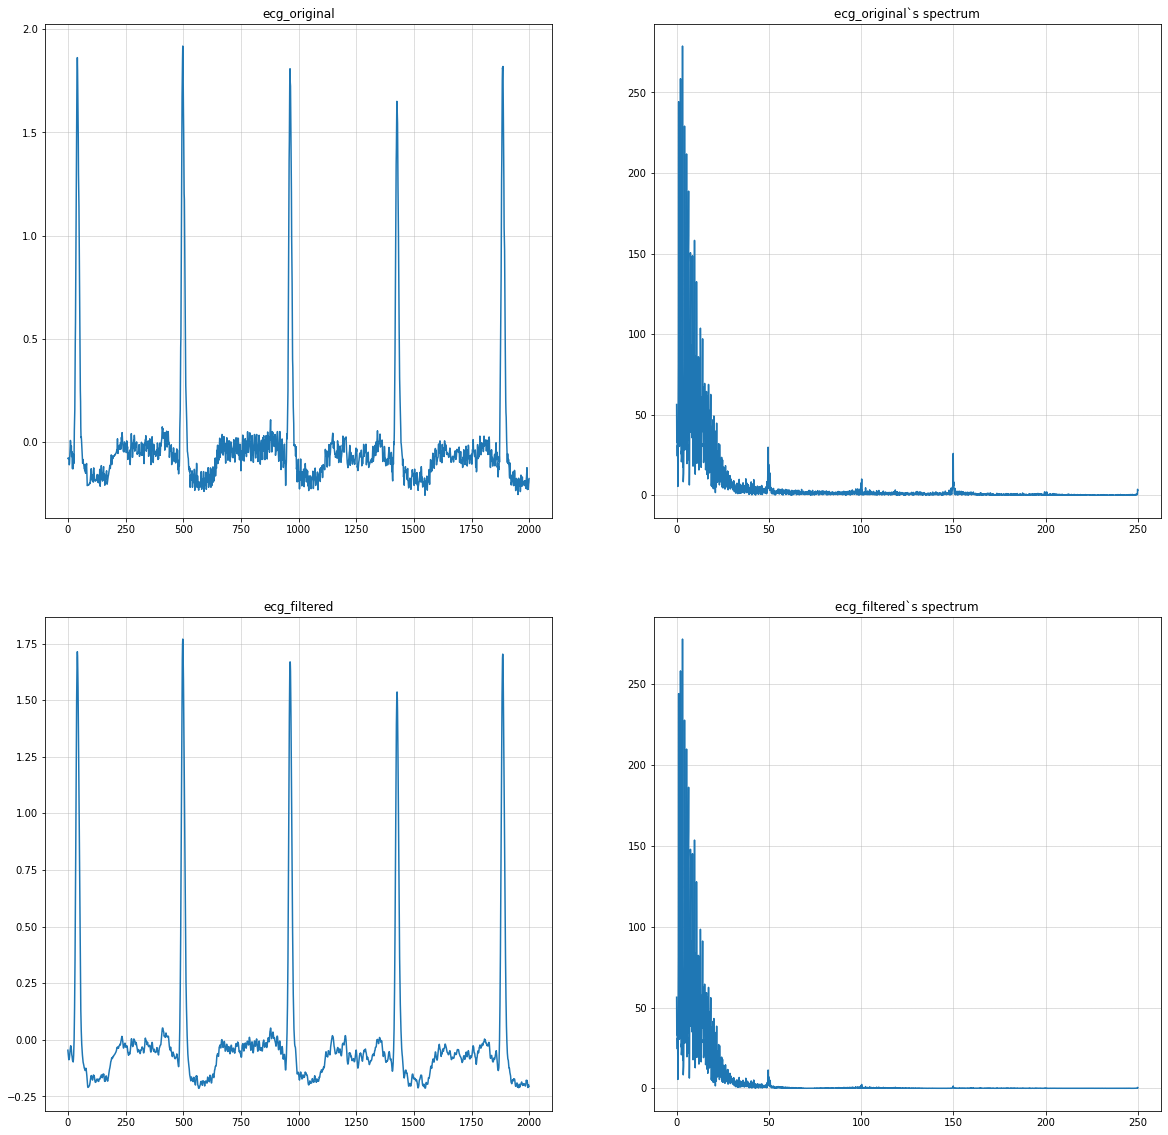

In [36]:
show_spec_dif(ecg_original, ecg_filtered, "ecg_original", "ecg_filtered")

### Filtering power frequency interference by Notch processing

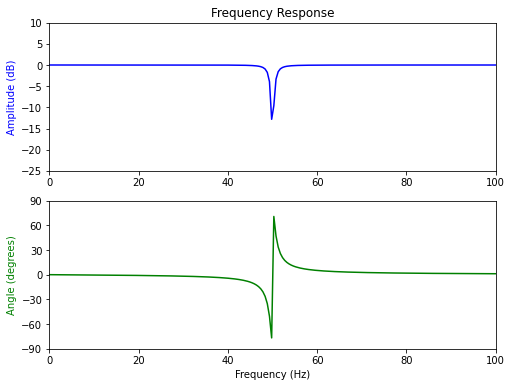

In [20]:
fs = sampling_rate  
f0 = 50.0   # nosie frequency to remove
Q = 30.0    # quality factor
b, a = signal.iirnotch(f0, Q, fs)
freq, h = signal.freqz(b, a, fs=fs)
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
ax[0].set_ylim([-25, 10])
ax[0].grid()
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid()
plt.show()

In [21]:
# filter power noise 50Hz
ecg_notch = signal.filtfilt(b, a, ecg_filtered) 

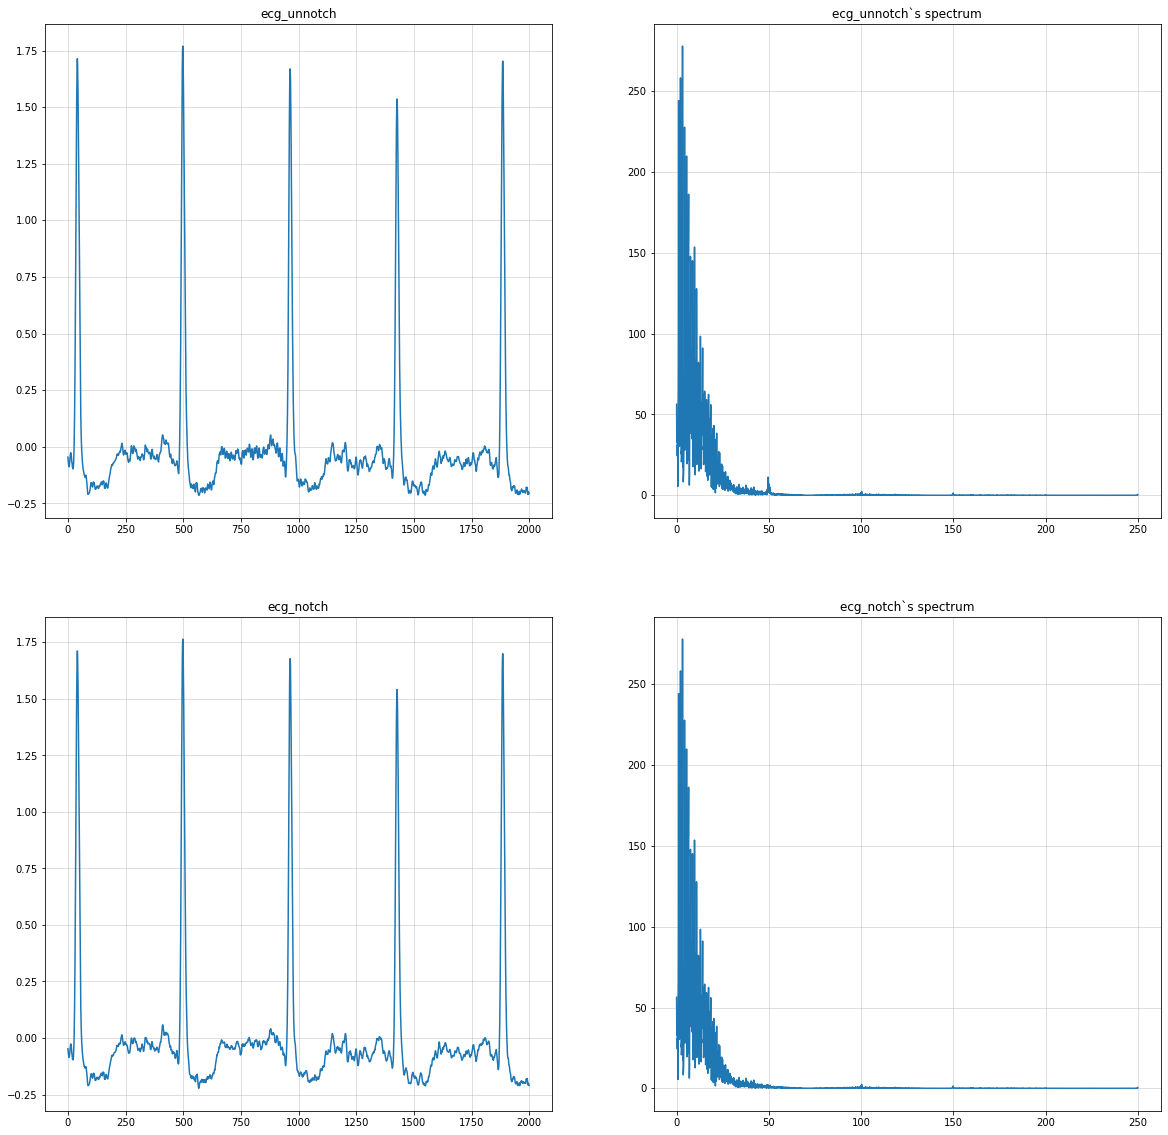

In [22]:
show_spec_dif(ecg_filtered, ecg_notch, "ecg_unnotch", "ecg_notch")

found that the power noise is not strong in some ecg signal...

In [23]:
# filter noise in all leads
channels = 12
X_filtered = np.ones_like(X)
for index in range(len(X)):
    if index % 1000 == 0:
        print("---index %d finished filtered, process : %d %%---" % (index, index/X.shape[0]*100)) 
    for channel in range(channels):
        X_filtered[index][:, channel] = np_move_avg(X[index][:, channel], 5)
print("---all files finished filtering, process 100% !---")

---index 0 finished filtered, process : 0 %---
---index 1000 finished filtered, process : 4 %---
---index 2000 finished filtered, process : 9 %---
---index 3000 finished filtered, process : 13 %---
---index 4000 finished filtered, process : 18 %---
---index 5000 finished filtered, process : 22 %---
---index 6000 finished filtered, process : 27 %---
---index 7000 finished filtered, process : 32 %---
---index 8000 finished filtered, process : 36 %---
---index 9000 finished filtered, process : 41 %---
---index 10000 finished filtered, process : 45 %---
---index 11000 finished filtered, process : 50 %---
---index 12000 finished filtered, process : 54 %---
---index 13000 finished filtered, process : 59 %---
---index 14000 finished filtered, process : 64 %---
---index 15000 finished filtered, process : 68 %---
---index 16000 finished filtered, process : 73 %---
---index 17000 finished filtered, process : 77 %---
---index 18000 finished filtered, process : 82 %---
---index 19000 finished filt

## ecg signal divide by R

In [55]:
# check R function
def checkR(ecg):
    max_val = np.max(ecg)
    min_val = np.min(ecg)
    threshold_val = (max_val-min_val)*0.7 + min_val
    index = []
    for i in range(1, len(ecg)-2):
        if ecg[i] == np.max(ecg[i-1:i+2]) and ecg[i] > threshold_val:
            if index != []:
                if i-index[-1] <= 60.0/40.0*sampling_rate and i-index[-1] >= 60.0/160.0*sampling_rate:
                    index.append(i)
            else:
                index.append(i)
    return np.array(index)

In [64]:
ecg = X[10086,:, 1]
index = checkR(ecg)

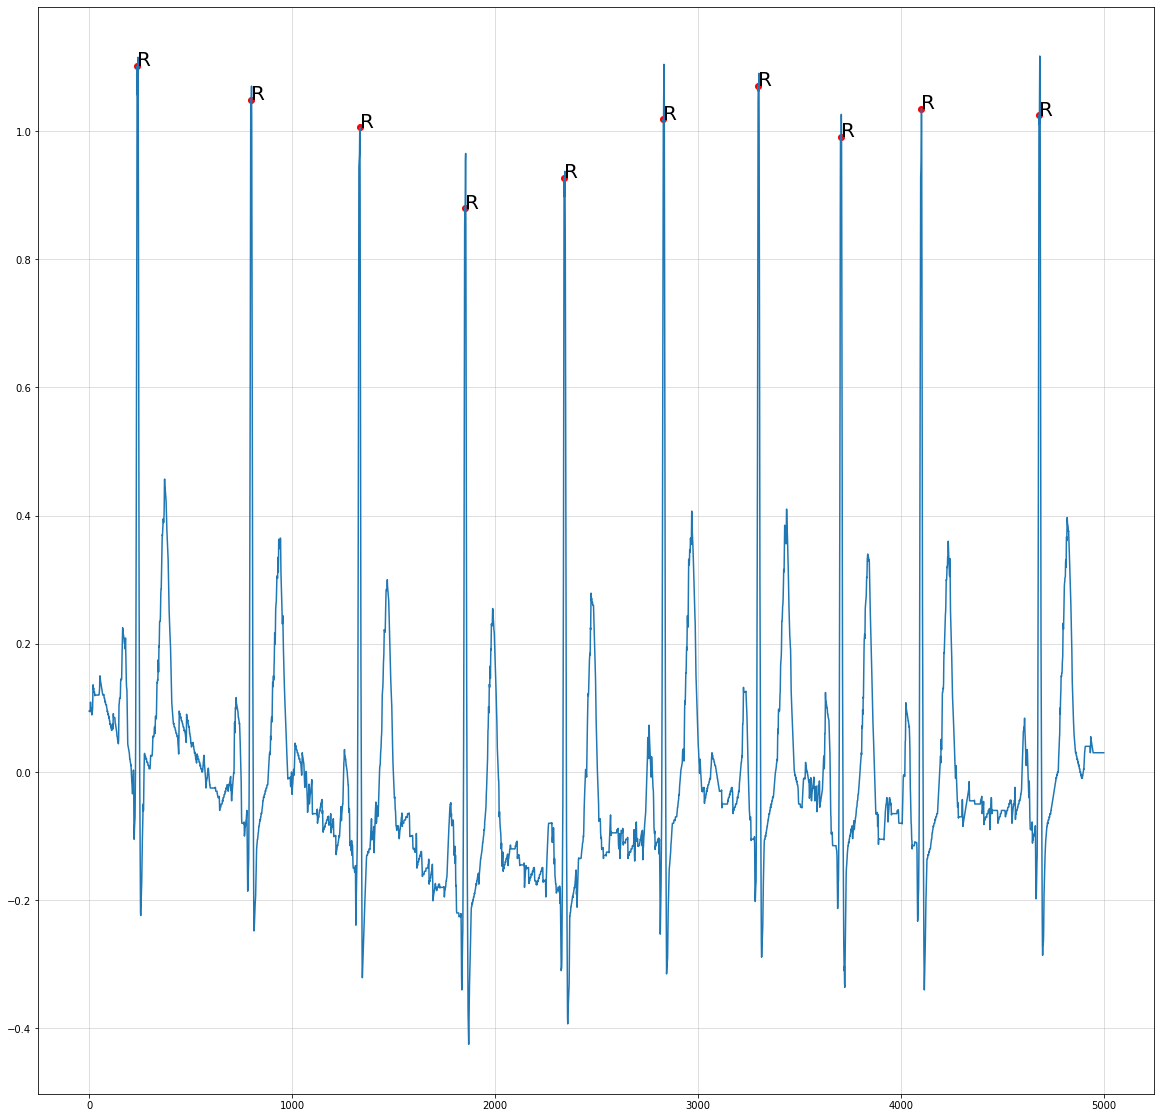

In [65]:
plt.figure()
plt.plot(ecg)
for i in range(len(index)):
    plt.scatter(index[i], ecg[index[i]],c='r')
    plt.annotate('R',(index[i], ecg[index[i]]), fontsize=20)
plt.show()

In [76]:
sum = 0
for i in range(len(index)-1):
    sum += index[i+1] - index[i]
sum /= len(index) - 1
print(sum)
# print(60*sampling_rate/sum)

493.6666666666667


In [79]:
def splitByR(ecg):
    index = checkR(ecg)     
    RR = 0
    for i in range(len(index)-1):
        RR += index[i+1] - index[i]
    RR /= (len(index)-1)         
    ecg_rhythm = None
    for i in range(len(index)):
        # 提取出一段
        if index[i]>RR/3 and index[i]<1000-RR*2/3:
            ecg_rhythm = ecg[index[i]-int(RR/3):index[i]+int(RR*2/3)]
    return ecg_rhythm

In [80]:
ecg_rhythm = splitByR(ecg)

In [81]:
ecg_rhythm.size

493